In [1]:
import HARK.ConsumptionSaving.ConsPortfolioFrameModel as cpfm
import HARK.ConsumptionSaving.ConsPortfolioModel as cpm

from HARK.frame import Frame, draw_frame_model
import numpy as np

from HARK.utilities import (
    CRRAutility,
)

The `FrameAgentType` is an alternative way to specify a model.

The library contains a demonstration of this form of model, `ConsPortfolioFrameModel`, which is a replica of the `ConsPortfolioModel`.

This notebook compares the results of simulations of the two models.

In [2]:
pct = cpm.PortfolioConsumerType(T_sim=5000, AgentCount=200)
pct.cycles = 0

# Solve the model under the given parameters

pct.solve()
pct.track_vars += [
    "mNrm",
    "cNrm",
    "Share",
    "aNrm",
    "Risky",
    "Adjust",
    "PermShk",
    "TranShk",
    "bNrm",
    "who_dies"
]

pct.make_shock_history()
pct.read_shocks = True

pct.initialize_sim()

pct.simulate()

{'mNrm': array([[8.7164524 , 2.03325586, 2.63518356, ..., 3.66314291, 1.96457511,
         2.35682562],
        [7.53817219, 2.10354946, 2.51176215, ..., 3.2255641 , 1.79321031,
         2.25975664],
        [7.51741489, 1.33419158, 2.58676818, ..., 2.99232575, 1.99446962,
         2.085719  ],
        ...,
        [3.47096891, 2.56314501, 1.93901266, ..., 5.77330299, 1.71385514,
         1.43386989],
        [3.18446855, 2.22548746, 1.69486961, ..., 4.45162859, 1.49321206,
         1.5101797 ],
        [4.04439079, 2.57326678, 2.02925706, ..., 6.24446068, 1.69535394,
         1.80758311]]),
 'cNrm': array([[1.60847121, 1.02920493, 1.10094396, ..., 1.20301058, 1.01974637,
         1.06965997],
        [1.52197254, 1.03849272, 1.08737054, ..., 1.1613557 , 0.99426674,
         1.05809853],
        [1.5204159 , 0.90171081, 1.09566232, ..., 1.1382064 , 1.02390805,
         1.0361757 ],
        ...,
        [1.1849682 , 1.09307659, 1.01614736, ..., 1.38473713, 0.9812697 ,
         0.9260751

In [3]:
pcft = cpfm.PortfolioConsumerFrameType(
    T_sim=5000,
    AgentCount=200,
    read_shocks = True
)

pcft.cycles = 0

# Solve the model under the given parameters
pcft.solve()
                       
pcft.track_vars += [
    "mNrm",
    "cNrm",
    "Share",
    "aNrm",
    "Adjust",
    "PermShk",
    "TranShk",
    "bNrm",
    'U'
]

pcft.shock_history = pct.shock_history
pcft.newborn_init_history = pct.newborn_init_history

pcft.initialize_sim()

pcft.simulate()

Finished cycle #1 in 0.014972925186157227 seconds, solution distance = 100.0
Finished cycle #2 in 0.01820850372314453 seconds, solution distance = 51.348207181883055
Finished cycle #3 in 0.017827987670898438 seconds, solution distance = 17.087772635804413
Finished cycle #4 in 0.017523527145385742 seconds, solution distance = 8.522764942790388
Finished cycle #5 in 0.01751232147216797 seconds, solution distance = 5.0968728741369596
Finished cycle #6 in 0.017127275466918945 seconds, solution distance = 3.3840571487090756
Finished cycle #7 in 0.017804622650146484 seconds, solution distance = 2.405486013903502
Finished cycle #8 in 0.016999483108520508 seconds, solution distance = 1.7940793244431283
Finished cycle #9 in 0.01668095588684082 seconds, solution distance = 1.3867304233120308
Finished cycle #10 in 0.016848325729370117 seconds, solution distance = 1.1015802993548078
Finished cycle #11 in 0.016885042190551758 seconds, solution distance = 0.8942354850378145
Finished cycle #12 in 0.01

Finished cycle #99 in 0.018867969512939453 seconds, solution distance = 0.0004854889436689547
Finished cycle #100 in 0.017899513244628906 seconds, solution distance = 0.0004508331306851687
Finished cycle #101 in 0.01838850975036621 seconds, solution distance = 0.00041862192893571404
Finished cycle #102 in 0.017809152603149414 seconds, solution distance = 0.00038868513865963905
Finished cycle #103 in 0.017702102661132812 seconds, solution distance = 0.0003608642625891889
Finished cycle #104 in 0.017343759536743164 seconds, solution distance = 0.0003350116974294437
Finished cycle #105 in 0.016787052154541016 seconds, solution distance = 0.0003109899480335798
Finished cycle #106 in 0.01663804054260254 seconds, solution distance = 0.00028867109021746273
Finished cycle #107 in 0.016649246215820312 seconds, solution distance = 0.00026793597459118246
Finished cycle #108 in 0.016678571701049805 seconds, solution distance = 0.0002486736705362702
Finished cycle #109 in 0.016707181930541992 secon

/home/sb/projects/HARK/HARK/core.py:548: UserWarning: The option for reading shocks was activated but the model requires state PermShkAgg, not contained in newborn_init_history.
  warn(
/home/sb/projects/HARK/HARK/core.py:548: UserWarning: The option for reading shocks was activated but the model requires state Rport, not contained in newborn_init_history.
  warn(
/home/sb/projects/HARK/HARK/core.py:548: UserWarning: The option for reading shocks was activated but the model requires state U, not contained in newborn_init_history.
  warn(
/home/sb/projects/HARK/HARK/core.py:740: UserWarning: The option for reading shocks was activated but the model requires state PermShkAgg, not contained in newborn_init_history.
  warn(
/home/sb/projects/HARK/HARK/core.py:740: UserWarning: The option for reading shocks was activated but the model requires state Rport, not contained in newborn_init_history.
  warn(
/home/sb/projects/HARK/HARK/core.py:740: UserWarning: The option for reading shocks was a

{'mNrm': array([[8.74374672, 8.78247019, 8.78247019, ..., 8.66448761, 8.59378221,
         8.70643981],
        [7.89931294, 8.01729552, 7.94126514, ..., 7.94126514, 7.24684574,
         7.82860754],
        [8.24805144, 8.46301105, 8.13539383, ..., 8.28535834, 8.24805144,
         8.46301105],
        ...,
        [2.71199951, 2.71199951, 2.6700473 , ..., 2.0175801 , 2.83527132,
         2.0175801 ],
        [2.64647937, 1.99401217, 2.76446195, ..., 2.64647937, 2.90339119,
         2.90339119],
        [2.36471223, 2.57967185, 2.36471223, ..., 2.36471223, 2.40201913,
         2.57967185]]),
 'cNrm': array([[1.61043765, 1.61043765, 1.61043765, ..., 1.61043765, 1.61043765,
         1.61043765],
        [1.54882011, 1.54882011, 1.54882011, ..., 1.54882011, 1.54882011,
         1.54882011],
        [1.57444828, 1.57444828, 1.57444828, ..., 1.57444828, 1.57444828,
         1.57444828],
        ...,
        [1.10917782, 1.10917782, 1.10917782, ..., 1.10917782, 1.10917782,
         1.1091778

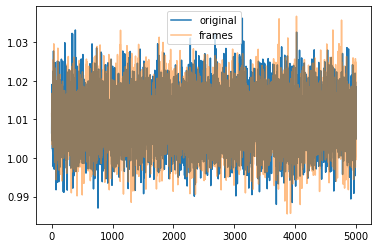

In [4]:
import matplotlib.pyplot as plt

plt.plot(range(5000), pct.history['PermShk'].mean(axis=1), label = 'original')
plt.plot(range(5000), pcft.history['PermShk'].mean(axis=1), label = 'frames', alpha = 0.5)
plt.legend()

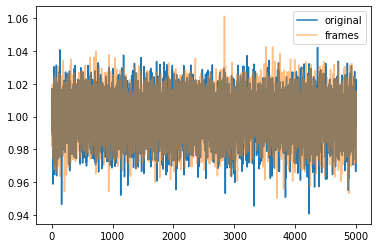

In [5]:
plt.plot(range(5000), pct.history['TranShk'].mean(axis=1), label = 'original')
plt.plot(range(5000), pcft.history['TranShk'].mean(axis=1), label = 'frames', alpha = 0.5)
plt.legend()

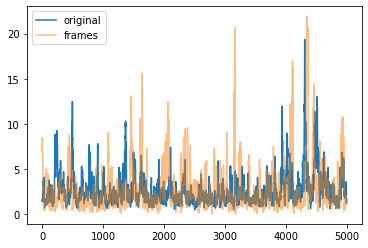

In [6]:
plt.plot(range(5000), pct.history['bNrm'].mean(axis=1), label = 'original')
plt.plot(range(5000), pcft.history['bNrm'].mean(axis=1), label = 'frames', alpha = 0.5)
plt.legend()

In [7]:
#plt.plot(range(5000), pct.history['Risky'].mean(axis=1), label = 'original')
#plt.plot(range(5000), pcft.history['Risky'].mean(axis=1), label = 'frames', alpha = 0.5)
#plt.legend()

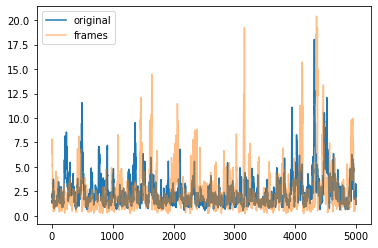

In [8]:
plt.plot(range(5000), pct.history['aNrm'].mean(axis=1), label = 'original')
plt.plot(range(5000), pcft.history['aNrm'].mean(axis=1), label = 'frames', alpha = 0.5)
plt.legend()

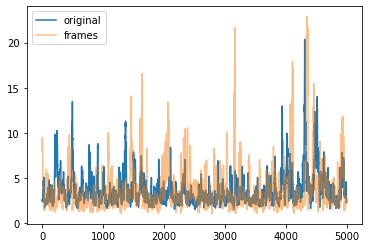

In [9]:
plt.plot(range(5000), pct.history['mNrm'].mean(axis=1), label = 'original')
plt.plot(range(5000), pcft.history['mNrm'].mean(axis=1), label = 'frames', alpha = 0.5)
plt.legend()

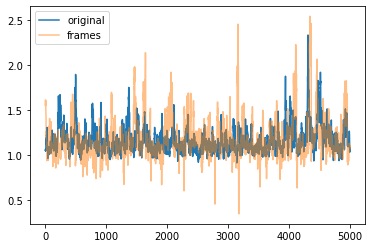

In [10]:
plt.plot(range(5000), pct.history['cNrm'].mean(axis=1), label = 'original')
plt.plot(range(5000), pcft.history['cNrm'].mean(axis=1), label = 'frames', alpha = 0.5)
plt.legend()

**TODO**: Handly Risky as an aggregate value.

In [11]:
#pct.history['Risky'][:3, :3]

In [12]:
#pcft.history['Risky'][:3, :3]

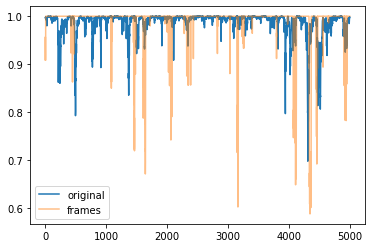

In [13]:
plt.plot(range(5000), pct.history['Share'].mean(axis=1), label = 'original')
plt.plot(range(5000), pcft.history['Share'].mean(axis=1), label = 'frames', alpha = 0.5)
plt.legend()

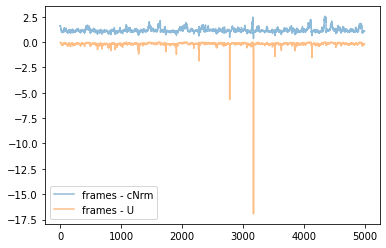

In [14]:
plt.plot(range(5000), pcft.history['cNrm'].mean(axis=1), label = 'frames - cNrm', alpha = 0.5)
plt.plot(range(5000), pcft.history['U'].mean(axis=1), label = 'frames - U', alpha = 0.5)
plt.legend()

In [15]:
pcft.history['U']

array([[-0.03716759, -0.03716759, -0.03716759, ..., -0.03716759,
        -0.03716759, -0.03716759],
       [-0.04344463, -0.04344463, -0.04344463, ..., -0.04344463,
        -0.04344463, -0.04344463],
       [-0.04068426, -0.04068426, -0.04068426, ..., -0.04068426,
        -0.04068426, -0.04068426],
       ...,
       [-0.16517157, -0.16517157, -0.16517157, ..., -0.16517157,
        -0.16517157, -0.16517157],
       [-0.16941998, -0.16941998, -0.16941998, ..., -0.16941998,
        -0.16941998, -0.16941998],
       [-0.19030626, -0.19030626, -0.19030626, ..., -0.19030626,
        -0.19030626, -0.19030626]])

In [16]:
pcft.history['U'].mean(axis=1)

array([-0.03716759, -0.04344463, -0.04068426, ..., -0.16517157,
       -0.16941998, -0.19030626])

In [17]:
pcft.history['U'][0,:]

array([-0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03

In [18]:
pcft.history['cNrm'][0,:]

array([1.61043765, 1.61043765, 1.61043765, 1.61043765, 1.61043765,
       1.61043765, 1.61043765, 1.61043765, 1.61043765, 1.61043765,
       1.61043765, 1.61043765, 1.61043765, 1.61043765, 1.61043765,
       1.61043765, 1.61043765, 1.61043765, 1.61043765, 1.61043765,
       1.61043765, 1.61043765, 1.61043765, 1.61043765, 1.61043765,
       1.61043765, 1.61043765, 1.61043765, 1.61043765, 1.61043765,
       1.61043765, 1.61043765, 1.61043765, 1.61043765, 1.61043765,
       1.61043765, 1.61043765, 1.61043765, 1.61043765, 1.61043765,
       1.61043765, 1.61043765, 1.61043765, 1.61043765, 1.61043765,
       1.61043765, 1.61043765, 1.61043765, 1.61043765, 1.61043765,
       1.61043765, 1.61043765, 1.61043765, 1.61043765, 1.61043765,
       1.61043765, 1.61043765, 1.61043765, 1.61043765, 1.61043765,
       1.61043765, 1.61043765, 1.61043765, 1.61043765, 1.61043765,
       1.61043765, 1.61043765, 1.61043765, 1.61043765, 1.61043765,
       1.61043765, 1.61043765, 1.61043765, 1.61043765, 1.61043

In [19]:
pcft.parameters['CRRA']

5.0

In [20]:
CRRAutility(pcft.history['cNrm'][0,:], 5)

array([-0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03716759,
       -0.03716759, -0.03716759, -0.03716759, -0.03716759, -0.03

# Visualizing the Transition Equations

Note that in the HARK `ConsIndShockModel`, from which the `ConsPortfolio` model inherits, the aggregate permanent shocks are considered to be portions of the permanent shocks experienced by the agents, not additions to those idiosyncratic shocks. Hence, they do not show up directly in the problem solved by the agent. This explains why the aggregate income levels are in a separarte component of the graph.

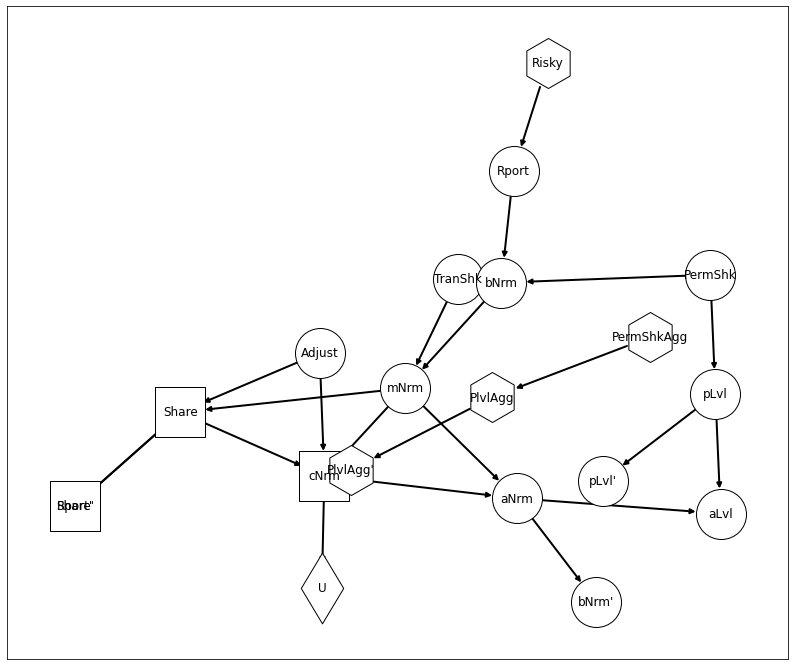

In [21]:
draw_frame_model(pcft.model, figsize=(14,12))

# Building the Solver [INCOMPLETE]

Preliminery work towards a generic solver for FramedAgentTypes.

In [22]:
controls = [frame for frame in pcft.frames.values() if frame.control]

In [23]:
def get_expected_return_function(control: Frame):
    # Input: a control frame
    # Returns: function of the control variable (control frame target)
    #      that returns the expected return, which is
    #          the sum of:
    #              - direct rewards
    #              - expected value of next-frame states (not yet implemented)
    #
    
    rewards = [child for child in control.children if child.reward]
    expected_values = [] # TODO
    
    ## note: function signature is what's needed for scipy.optimize
    def expected_return_function(x, *args):
        ##   returns the sum of 
        ##     the reward functions evaluated in context of
        ##       - parameters
        ##       - the control variable input
        
        # x - array of inputs, here the control frame target
        # args - a tuple of other parameters needed to complete the function
        
        expected_return = 0
        
        for reward in rewards:
            ## TODO: figuring out the ordering of `x` and `args` needed for multiple downstream scopes
            
            
            local_context = {}
            
            # indexing through the x and args values
            i = 0
            num_control_vars = None
            
            # assumes that all frame scopes list model variables first, parameters later
            # should enforce or clarify at the frame level.
            for var in reward.scope:
                if var in control.target:
                    local_context[var] = x[i]
                    i = i + 1
                elif var in pcft.parameters:
                    if num_control_vars is None:
                        num_control_vars = i
                    
                    local_context[var] = args[i - num_control_vars]
                    i = i + 1
                    
            # can `self` be implicit here?
            expected_return += reward.transition(reward, **local_context)
        
        return expected_return
    
    return expected_return_function            

In [24]:
def optimal_policy_function(control: Frame):
    
    erf = get_expected_return_function(control)
    constraints = control.constraints ## these will reference the context of the control transition, including scope
    
    ## Returns function:
    ##   input: control frame scope
    ##   output: result of scipy.optimize of the erf with respect to constraints
    ##           getting the optimal input (control variable) value
    return func
    

In [25]:
def approximate_optimal_policy_function(control, grid):
    ## returns a new function:
    ##   that is an interpolation over optimal_policy_function
    ##   over the grid
    
    return func